# Twitter Climate Change Sentiment Analysis

- Author: Roelle Kim
- Date: 2022-04-05


# Used Dataset

"Twitter Climate Change Sentiment" at https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset.


# Objective

The goal for the model is to distinguish tweets about climate change into one of the three labels:

- 2: news - factual news about the climate change
- 1: pro - support the belief that climate change is caused by the man-kinds.
- 0: neutral
- -1: anti - refuse the belief that climate change is caused by the man-kinds


# EDA


## Load Packages and Data

Before analyzing data, we need to import required packages and the dataset.


In [240]:
# pip install pydataset

In [241]:
# import packages
import pandas as pd
import numpy as np
from os import makedirs
from os import path
import math
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import nltk.downloader
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.util import ngrams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn import metrics
from pydataset import data
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import RandomOverSampler

import pickle
import json

import kagglehub
from kagglehub import KaggleDatasetAdapter

In [242]:
file_path = "twitter_sentiment_data.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "edqian/twitter-climate-change-sentiment-dataset",
    file_path,
)

/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_58910/2489314432.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


In [243]:
# drop rows where sentiment is 2 (news)
df = df[df["sentiment"] != 2]
df.reset_index(drop=True, inplace=True)

In [244]:
# set up label dataframe for future refrences

label = [
    -1,
    0,
    1,
    #  2
]
labelN = [
    "Anti",
    "Neutral",
    "Pro",
    #   "News"
]
labelDesc = [
    "the tweet does not believe in man-made climate change",
    "the tweet neither supports nor refutes the belief of man-made climate change",
    "the tweet supports the belief of man-made climate change",
    # , "the tweet links to factual news about climate change"
]

labelDf = pd.DataFrame(
    list(zip(label, labelN, labelDesc)), columns=["label", "name", "description"]
)

## Data Dictionary


In [245]:
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the p...,792927353886371840
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...",793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...,793124635873275904
4,0,Unamshow awache kujinga na iko global warming https://t.co/mhIflU7M1X,793125429418815489


The data has a very simple structure with only 2 features. Each row is associated with a unique tweetid, and it shows a tweet pertaining to man-made climate change. The message column shows the content of the tweet and the sentiment column shows the sentiment label that was determined by 3 reviewers.


In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34667 entries, 0 to 34666
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  34667 non-null  int64 
 1   message    34667 non-null  object
 2   tweetid    34667 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 812.6+ KB


There are total of 43949 entries with no null counts.


## Distribution of Sentiments


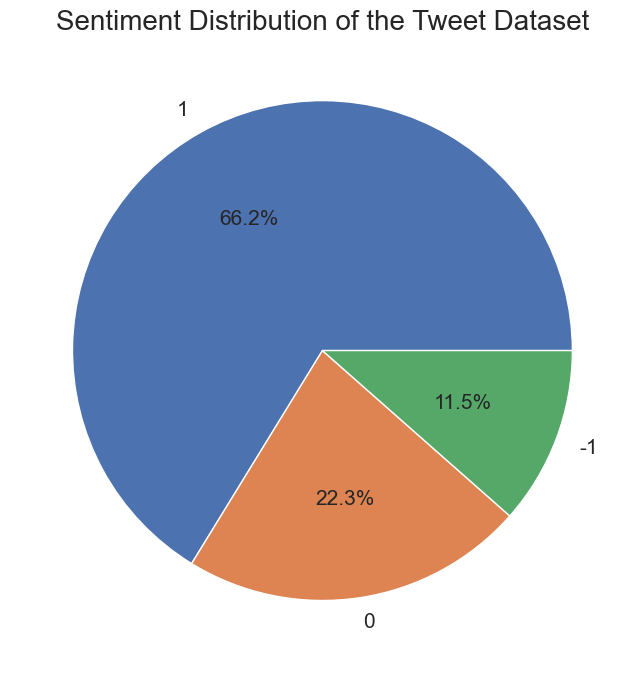

In [247]:
plt.figure(figsize=(7, 7))
plt.pie(
    df.sentiment.value_counts().values,
    labels=df.sentiment.value_counts().index,
    autopct="%2.1f%%",
    textprops={"fontsize": 15},
)
plt.title("Sentiment Distribution of the Tweet Dataset", fontsize=20)
plt.tight_layout()
plt.show()

The pie chart shows the distribution of the data. Majority of tweets are labelled as "1" meaning the positive attitude toward the belief that the climate change is caused by the man-kinds, followed by "2"(news), "0"(neutral), and "-1"(anti).


In [248]:
df.sentiment.value_counts()

sentiment
 1    22962
 0     7715
-1     3990
Name: count, dtype: int64

These are the exact numbers of each sentiment label.


# Data Preparation for Sentiment Analysis

Tweet texts will be transformed and vectorized to be fed into models.


In [249]:
# Remove duplicates from the dataframe first, then extract messages
df = df.drop_duplicates(subset=["message"])
df.reset_index(drop=True, inplace=True)

# Now separate the messages column for transformation.
dfTweets = df["message"]

print(f"Dataset size after removing duplicates: {len(df)}")
print(f"dfTweets size: {len(dfTweets)}")

Dataset size after removing duplicates: 31962
dfTweets size: 31962


In [250]:
df = df.drop_duplicates(subset=["message"])
df.reset_index(drop=True, inplace=True)

In [251]:
dfTweets

0        @tiniebeany climate change is an interesting hustle as it was global warming but the p...
1        RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...
2        Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...
3        RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...
4                            Unamshow awache kujinga na iko global warming https://t.co/mhIflU7M1X
                                                   ...                                            
31957         #AikBaatSuniThi \nGlobal warming has negative effect on the melting down of glaciers
31958    Dear @realDonaldTrump,\nYeah right. Human Mediated Climate Change is a Chinese urban l...
31959          What will your respective parties do to prevent climate change globally? #ZPNDebate
31960    RT @taehbeingextra: i still can$q$t believe this gif of taehyung saved the human race,...
31961    @

## Tokenization

All the tweets are first split into arrays of words.


In [252]:
def createTokenizedArray(sentences):
    """
    Create lower case array of words with no punctuation.
    :param sentences: array or series of texts
    :return: lower case array of words with no punctuation.
    """
    # Initialize tokenizer and empty array to store modified sentences.
    tokenizer = RegexpTokenizer(r"\w+")
    tokenizedArray = []
    for i in range(0, len(sentences)):
        # Convert sentence to lower case.
        sentence = sentences[i].lower()

        # Split sentence into array of words with no punctuation.
        words = tokenizer.tokenize(sentence)

        # Append word array to list.
        tokenizedArray.append(words)

    # print(tokenizedArray)
    return tokenizedArray  # send modified contents back to calling function.

In [253]:
tokenizedLi = createTokenizedArray(dfTweets)

pd.Series(tokenizedLi[:5])

0    [tiniebeany, climate, change, is, an, interesting, hustle, as, it, was, global, warmin...
1    [rt, natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the,...
2    [fabulous, leonardo, dicaprio, s, film, on, climate, change, is, brilliant, do, watch,...
3    [rt, mick_fanning, just, watched, this, amazing, documentary, by, leonardodicaprio, on...
4              [unamshow, awache, kujinga, na, iko, global, warming, https, t, co, mhiflu7m1x]
dtype: object

Each array contains words of individual tweet.


## Stop Word Removal

Stop words are the words that do not add any significant values to the query search, such as "the", "a", and "an". They are safe to be removed from the tokenized list.


In [254]:
# To get stop words.
nltk.download("stopwords")


def removeStopWords(tokenList):
    """
    Create array of words with no punctuation or stop words.
    :param tokenList: tokenized list
    :return: array of words with no punctuation or stop words.
    """
    stopWords = set(stopwords.words("english"))
    shorterSentences = []  # Declare empty array of sentences.

    for sentence in tokenList:
        shorterSentence = []  # Declare empty array of words in single sentence.
        for word in sentence:
            if word not in stopWords:
                # Remove leading and trailing spaces.
                word = word.strip()

                # Ignore single character words and digits.
                if len(word) > 1 and word.isdigit() == False:
                    # Add remaining words to list.
                    shorterSentence.append(word)
        shorterSentences.append(shorterSentence)
    return shorterSentences

[nltk_data] Downloading package stopwords to /Users/nafis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [255]:
tokenizedNoStopLi = removeStopWords(tokenizedLi)

print(f"Sample sentence BEFORE removing stop words:\n{tokenizedLi[0]}")
print(f"\n\nSample sentence AFTER removing stop words:\n{tokenizedNoStopLi[0]}")

Sample sentence BEFORE removing stop words:
['tiniebeany', 'climate', 'change', 'is', 'an', 'interesting', 'hustle', 'as', 'it', 'was', 'global', 'warming', 'but', 'the', 'planet', 'stopped', 'warming', 'for', '15', 'yes', 'while', 'the', 'suv', 'boom']


Sample sentence AFTER removing stop words:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']


You can see the second set of the array now no longer contains some insignificant words such as "is", "an", "as" and "it".


## Stemming

English words are often time variations of a root word. Stemming rebuilds sentences by removing suffixes from words. It potentially improves the sentiment algorithm by accepting different words as one word as long as they were originated from the same stem.


In [256]:
def stemWords(sentenceArrays):
    """
    Removes suffixes and rebuilds the sentences.
    :param sentenceArrays: stentences list
    :return: array of sentences without suffixes
    """
    ps = PorterStemmer()
    stemmedSentences = []
    for sentenceArray in sentenceArrays:
        stemmedArray = []  # Declare empty array of words.
        for word in sentenceArray:
            stemmedArray.append(ps.stem(word))  # Add stemmed word.

        # Convert array back to sentence of stemmed words.
        delimeter = " "
        sentence = delimeter.join(stemmedArray)

        # Append stemmed sentence to list of sentences.
        stemmedSentences.append(sentence)
    return stemmedSentences

In [257]:
stemmedLi = stemWords(tokenizedNoStopLi)

print(f"Sample sentence BEFORE stemming:\n{tokenizedNoStopLi[:5]}")
print(f"\nSample sentence AFTER stemming:\n{stemmedLi[:5]}")

Sample sentence BEFORE stemming:
[['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom'], ['rt', 'natgeochannel', 'watch', 'beforetheflood', 'right', 'leodicaprio', 'travels', 'world', 'tackle', 'climate', 'change', 'https', 'co', 'lkdehj3tnn', 'httã'], ['fabulous', 'leonardo', 'dicaprio', 'film', 'climate', 'change', 'brilliant', 'watch', 'https', 'co', '7rv6brmxjw', 'via', 'youtube'], ['rt', 'mick_fanning', 'watched', 'amazing', 'documentary', 'leonardodicaprio', 'climate', 'change', 'think', 'thisã', 'https', 'co', 'knste8k8im'], ['unamshow', 'awache', 'kujinga', 'na', 'iko', 'global', 'warming', 'https', 'co', 'mhiflu7m1x']]

Sample sentence AFTER stemming:
['tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom', 'rt natgeochannel watch beforetheflood right leodicaprio travel world tackl climat chang http co lkdehj3tnn httã', 'fabul leonardo dicaprio film climat chang brillia

You can see the sentence after stemming has lost some suffixes. "Change" became "chang", "interesting" became "interest" and "warming" became "warm". The array of words has also been converted back to one full sentence.


## Vectorization

Now the stemmed sentences will be vectorized. It essentially transforms all the existing words into numbers so they can be fed to various big data algorithms.


In [258]:
def vectorizeList(stemmedList, ngramRangeStart, ngramRangeEnd):
    """
    Creates a matrix of word vectors.
    :param stemmedList: stemmed sentence list
    :return: matrix of word vectors and vocabulary dictionary
    """
    cv = CountVectorizer(binary=True, ngram_range=(ngramRangeStart, ngramRangeEnd))
    cv.fit(stemmedList)
    X = cv.transform(stemmedList)

    return X, cv.vocabulary_

In [259]:
vectorizedTweets, vectorDictionary = vectorizeList(stemmedLi, 1, 1)

Let's look into 2 different sample sentences to understand better what vectorization does


In [260]:
print(f"Sample sentence #1:\n{stemmedLi[0]}")
print(f"Sample sentence #2:\n{stemmedLi[1]}")

Sample sentence #1:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom
Sample sentence #2:
rt natgeochannel watch beforetheflood right leodicaprio travel world tackl climat chang http co lkdehj3tnn httã


Notice these 2 sentences have a couple of words in common - "climat", "chang"


In [261]:
print(f"\n#1 after vectorization:\n{vectorizedTweets[0]}")
print(f"#2 after vectorization:\n{vectorizedTweets[1]}")


#1 after vectorization:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 12 stored elements and shape (1, 54331)>
  Coords	Values
  (0, 8170)	1
  (0, 10062)	1
  (0, 10801)	1
  (0, 19704)	1
  (0, 22345)	1
  (0, 23653)	1
  (0, 36745)	1
  (0, 44393)	1
  (0, 44948)	1
  (0, 46697)	1
  (0, 50288)	1
  (0, 52533)	1
#2 after vectorization:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 15 stored elements and shape (1, 54331)>
  Coords	Values
  (0, 7109)	1
  (0, 10062)	1
  (0, 10801)	1
  (0, 11188)	1
  (0, 22189)	1
  (0, 22197)	1
  (0, 28183)	1
  (0, 28688)	1
  (0, 32626)	1
  (0, 40094)	1
  (0, 40752)	1
  (0, 45292)	1
  (0, 47234)	1
  (0, 50354)	1
  (0, 51349)	1


The prints above show the results of 2 sample sentences after being ve. Each vector signifies a unique word in all tweets. For example, we already know they have 2 words in common; therefore, we can see 2 sets of vectors appearing in both sentences - **(0, 12943)** and **(0, 13774)** - which are representations of "climat" and "chang" respectively.


In [262]:
vectorizedTweets.shape

(31962, 54331)

Based on the column size of our vectorized data, we can see there were 67195 unique words (no stop words, stemmed) in 43943 tweets in the dataset.


## Unigram & Bigram Vectorization

The analysis focuses on unigram (single words) and unigram+bigram (1-2 word combinations) to find the most meaningful patterns for sentiment analysis while maintaining computational efficiency.


# Model Development

Various models will be built to predict the sentiment of tweets pertaining to climate change.


In [263]:
def evaluateModel(model, X_test, y_test, title):
    """
    print out classification scores
    :param model: used model
    :param X_test:
    :param y_test:
    :param title: title of the model
    """
    print("\n*** " + title + " ***")
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions, average="weighted")
    precision = metrics.precision_score(y_test, predictions, average="weighted")
    f1 = metrics.f1_score(y_test, predictions, average="weighted")

    clsScoreDict = {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1,
    }

    print("Accuracy:  " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall:    " + str(recall))
    print("F1:        " + str(f1))
    print("\n\n")

    return clsScoreDict

In [264]:
def modelAndPredict(X, target, model):
    """
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    """

    modelType = model.__class__.__name__
    
    # Create training set with 80% of data and test set with 20% of data.
    X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=0.8, random_state=42)
    
    print(f"Test set shape: X_test={X_test.shape}, y_test={len(y_test)}")

    # Apply oversampling to handle class imbalance.
    X_train_res, y_train_res = oversampleTrainingData(X_train, y_train)

    # Build the model with the resampled training data.
    clfModel = model.fit(X_train_res, y_train_res)
    clsScoreDict = evaluateModel(clfModel, X_test, y_test, modelType)

    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict


### Oversampling Function

The `oversampleTrainingData` function handles class imbalance by using SMOTE (Synthetic Minority Oversampling Technique) via `RandomOverSampler`. This creates synthetic samples for minority classes to balance the training dataset, which can improve model performance on imbalanced datasets.


In [265]:
def oversampleTrainingData(X_train, y_train, random_state=42):
    """
    Apply oversampling to training data to handle class imbalance.
    
    :param X_train: Training features
    :param y_train: Training target labels
    :param random_state: Random state for reproducibility
    :return: Resampled training features and labels
    """
    oversampler = RandomOverSampler(random_state=random_state)
    X_train_res, y_train_res = oversampler.fit_resample(X_train, y_train)
    
    print(f"Original training set shape: X_train={X_train.shape}, y_train={len(y_train)}")
    print(f"Resampled training set shape: X_train_res={X_train_res.shape}, y_train_res={len(y_train_res)}")
    
    return X_train_res, y_train_res

In [266]:
def showFormattedConfusionMatrix(y_test, y_predicted):
    """
    Draw the confusion matrix.
    :param y_test
    :param y_predicted
    :return:
    """
    # print a simple confusion matrix
    cm = metrics.confusion_matrix(y_test.values, y_predicted)
    print(cm)

    # Show confusion matrix with colored background.
    Index = [
        "Actual -1",
        "Actual 0",
        "Actual 1",
        #  'Actual 2',
    ]
    Cols = [
        "Pred -1",
        "Pred 0",
        "Pred 1",
        # 'Pred 2'
    ]
    df = pd.DataFrame(cm, index=Index, columns=Cols)
    plt.figure(figsize=(4, 4))

    ax = sns.heatmap(df, cmap="Blues", annot=True, fmt="g")
    bottom, top = ax.get_ylim()
    ax.set(title="Climate Change Sentiment")
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment="right")

In [267]:
# unigram & bi-gram vectorization
NGRAM_RANGE_START = 1
NGRAM_RANGE_END = 2

vectorizedTweets12, vectorDictionary12 = vectorizeList(
    stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END
)

## 1. Logistic Regression


In [268]:
model = LogisticRegression(
    random_state=42,
)

Test set shape: X_test=(6393, 54331), y_test=6393
Original training set shape: X_train=(25569, 54331), y_train=25569
Resampled training set shape: X_train_res=(49362, 54331), y_train_res=49362

*** LogisticRegression ***
Accuracy:  0.7541060534960112
Precision: 0.7576762339585478
Recall:    0.7541060534960112
F1:        0.7557060473063105



[[ 488  148  130]
 [ 114  876  490]
 [ 140  550 3457]]

*** LogisticRegression ***
Accuracy:  0.7541060534960112
Precision: 0.7576762339585478
Recall:    0.7541060534960112
F1:        0.7557060473063105



[[ 488  148  130]
 [ 114  876  490]
 [ 140  550 3457]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


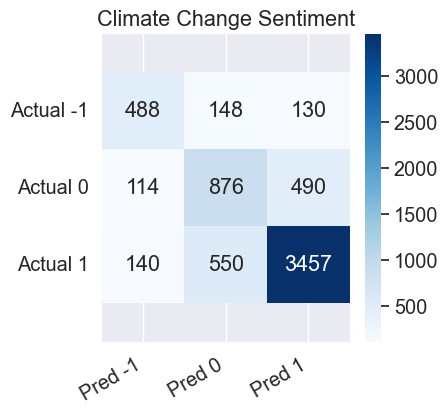

In [269]:
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Unigram & Bigram Combined Logistic Regression


Test set shape: X_test=(6393, 263499), y_test=6393
Original training set shape: X_train=(25569, 263499), y_train=25569
Resampled training set shape: X_train_res=(49362, 263499), y_train_res=49362

*** LogisticRegression ***
Accuracy:  0.7786641639292977
Precision: 0.7730517116593588
Recall:    0.7786641639292977
F1:        0.7748631453090075



[[ 473  136  157]
 [  92  846  542]
 [  91  397 3659]]

*** LogisticRegression ***
Accuracy:  0.7786641639292977
Precision: 0.7730517116593588
Recall:    0.7786641639292977
F1:        0.7748631453090075



[[ 473  136  157]
 [  92  846  542]
 [  91  397 3659]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


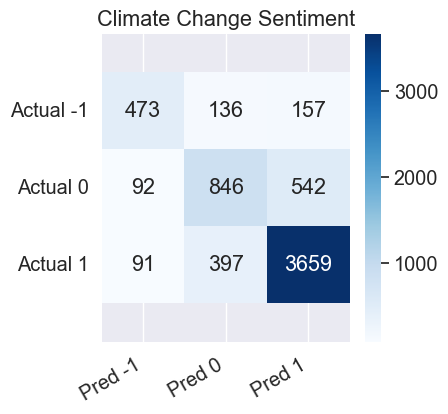

In [270]:
X_test, y_test, y_predicted, lrScoreDict12 = modelAndPredict(
    vectorizedTweets12, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### N-gram Comparisons

We have built different vectorized sentences using different ranges of N-grams (1, 2, 3, 1-2 combined, and 2 to 3). Each of them was fed to a logistic regression model and evaluated based on classification scores such as accuracy, precision, recall and F1. In this section, we will compare all the scores and see what N-gram has worked the best.


In [271]:
lsScoreDf = pd.DataFrame(lrScoreDict, index=["Unigram"])
lsScoreDf12 = pd.DataFrame(lrScoreDict12, index=["Unigram & Bi-gram"])

lsScoreComparisonDf = pd.concat([lsScoreDf, lsScoreDf12])
lsScoreComparisonDf

,accuracy,recall,precision,f1
Unigram,0.754106,0.754106,0.757676,0.755706
Unigram & Bi-gram,0.778664,0.778664,0.773052,0.774863


Logistic regression has worked the best when no N-gram was used to vectorize the sentences. Let's see if we can improve the model even further using different classification models.


## 2. Random Forest Classifier


In [272]:
model = RandomForestClassifier(random_state=42)

Test set shape: X_test=(6393, 54331), y_test=6393
Original training set shape: X_train=(25569, 54331), y_train=25569
Resampled training set shape: X_train_res=(49362, 54331), y_train_res=49362

*** RandomForestClassifier ***

*** RandomForestClassifier ***
Accuracy:  0.7514468950414516
Precision: 0.7452361827906173
Recall:    0.7514468950414516
F1:        0.7410343007589106



Accuracy:  0.7514468950414516
Precision: 0.7452361827906173
Recall:    0.7514468950414516
F1:        0.7410343007589106



[[ 330  169  267]
 [  61  780  639]
 [  40  413 3694]]
[[ 330  169  267]
 [  61  780  639]
 [  40  413 3694]]


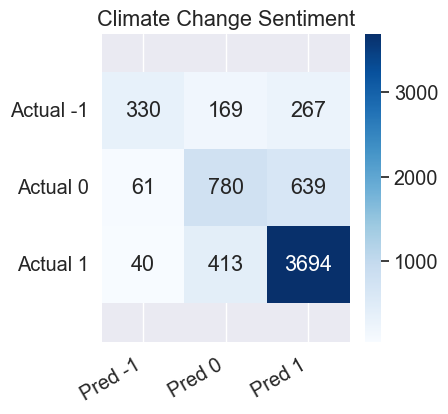

In [273]:
X_test, y_test, y_predicted, rfScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

## 3. Multinomial Naive Bayes


In [274]:
model = MultinomialNB()

Test set shape: X_test=(6393, 54331), y_test=6393
Original training set shape: X_train=(25569, 54331), y_train=25569
Resampled training set shape: X_train_res=(49362, 54331), y_train_res=49362

*** MultinomialNB ***
Accuracy:  0.7193805725011732
Precision: 0.7339457465532707
Recall:    0.7193805725011732
F1:        0.7206508719551667



[[ 575   91  100]
 [ 308  654  518]
 [ 361  416 3370]]


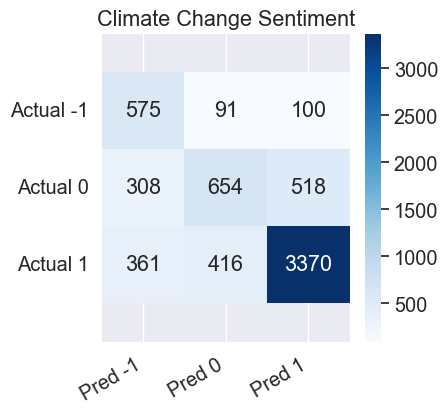

In [275]:
X_test, y_test, y_predicted, nbScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Unigram & Bigram Combined Multinomial Naive Bayes


Test set shape: X_test=(6393, 263499), y_test=6393
Original training set shape: X_train=(25569, 263499), y_train=25569
Resampled training set shape: X_train_res=(49362, 263499), y_train_res=49362

*** MultinomialNB ***
Accuracy:  0.7439386829344595
Precision: 0.7476699197782319
Recall:    0.7439386829344595
F1:        0.7423579268818761



[[ 559   87  120]
 [ 260  703  517]
 [ 249  404 3494]]


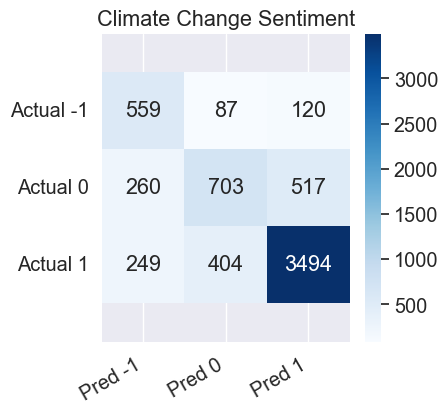

In [276]:
X_test, y_test, y_predicted, nbScoreDict12 = modelAndPredict(
    vectorizedTweets12, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

## 4. Ridge Classifier


In [277]:
model = RidgeClassifier(random_state=42)

Test set shape: X_test=(6393, 54331), y_test=6393
Original training set shape: X_train=(25569, 54331), y_train=25569
Resampled training set shape: X_train_res=(49362, 54331), y_train_res=49362

*** RidgeClassifier ***
Accuracy:  0.7387767871109026
Precision: 0.7342718852996116
Recall:    0.7387767871109026
F1:        0.7356158576750703



[[ 417  160  189]
 [ 113  776  591]
 [  99  518 3530]]

*** RidgeClassifier ***
Accuracy:  0.7387767871109026
Precision: 0.7342718852996116
Recall:    0.7387767871109026
F1:        0.7356158576750703



[[ 417  160  189]
 [ 113  776  591]
 [  99  518 3530]]


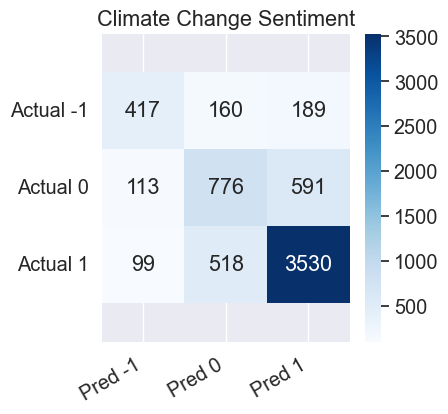

In [278]:
X_test, y_test, y_predicted, ridgeScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Unigram & Bigram Combined Ridge Classifier


Test set shape: X_test=(6393, 263499), y_test=6393
Original training set shape: X_train=(25569, 263499), y_train=25569
Resampled training set shape: X_train_res=(49362, 263499), y_train_res=49362

*** RidgeClassifier ***
Accuracy:  0.7803847958704834
Precision: 0.7741396074681536
Recall:    0.7803847958704834
F1:        0.7729450334821516



[[ 426  152  188]
 [  65  810  605]
 [  40  354 3753]]

*** RidgeClassifier ***
Accuracy:  0.7803847958704834
Precision: 0.7741396074681536
Recall:    0.7803847958704834
F1:        0.7729450334821516



[[ 426  152  188]
 [  65  810  605]
 [  40  354 3753]]


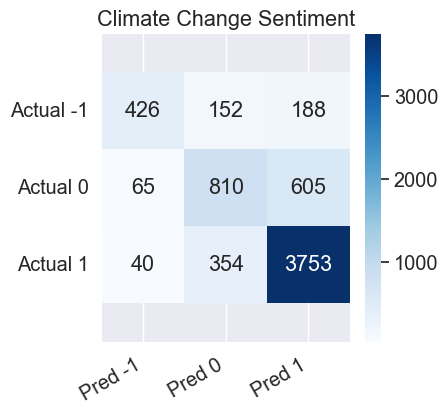

In [279]:
X_test, y_test, y_predicted, ridgeScoreDict12 = modelAndPredict(
    vectorizedTweets12, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

# Model Comparisons


In [280]:
# Logistic Regression scores for different N-grams  
lrScoreDf = pd.DataFrame(lrScoreDict, index=["Logistic Regression (Unigram)"])
lrScoreDf12 = pd.DataFrame(lrScoreDict12, index=["Logistic Regression (Unigram & Bi-gram)"])

# Random Forest scores for different N-grams
rfScoreDf = pd.DataFrame(rfScoreDict, index=["Random Forest (Unigram)"])

# Multinomial Naive Bayes scores for different N-grams
nbScoreDf = pd.DataFrame(nbScoreDict, index=["Multinomial Naive Bayes (Unigram)"])
nbScoreDf12 = pd.DataFrame(nbScoreDict12, index=["Multinomial Naive Bayes (Unigram & Bi-gram)"])

# Ridge Classifier scores for different N-grams
ridgeScoreDf = pd.DataFrame(ridgeScoreDict, index=["Ridge Classifier (Unigram)"])
ridgeScoreDf12 = pd.DataFrame(ridgeScoreDict12, index=["Ridge Classifier (Unigram & Bi-gram)"])

# Combine all model results - only unigram and unigram+bigram
clsCompDf = pd.concat([
    # Logistic Regression
    lrScoreDf, lrScoreDf12,
    # Random Forest
    rfScoreDf,
    # Multinomial Naive Bayes
    nbScoreDf, nbScoreDf12,
    # Ridge Classifier
    ridgeScoreDf, ridgeScoreDf12
])

clsCompDf.sort_values(by=["accuracy", "f1"], ascending=False)

,accuracy,recall,precision,f1
Ridge Classifier (Unigram & Bi-gram),0.780385,0.780385,0.774140,0.772945
Logistic Regression (Unigram & Bi-gram),0.778664,0.778664,0.773052,0.774863
Logistic Regression (Unigram),0.754106,0.754106,0.757676,0.755706
Random Forest (Unigram),0.751447,0.751447,0.745236,0.741034
Multinomial Naive Bayes (Unigram & Bi-gram),0.743939,0.743939,0.747670,0.742358
Ridge Classifier (Unigram),0.738777,0.738777,0.734272,0.735616
Multinomial Naive Bayes (Unigram),0.719381,0.719381,0.733946,0.720651


We can compare the performance of our four selected models: **Logistic Regression**, **Random Forest Classifier**, **Multinomial Naive Bayes**, and **Ridge Classifier** based on their accuracy, precision, recall, and F1 scores.


# Binary File Export

To reuse the built model to predict other tweets, we will be saving the model as a binary file.


In [281]:
def modelAndPredict(X, target, model):
    """
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    """

    modelType = model.__class__.__name__

    # Create training set with 75% of data and test set with 25% of data.
    X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=0.75, random_state=42)

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)

    # save model to a pickle file
    # create directory for models
    if not path.exists("./model"):
        makedirs("./model")
    pickle.dump(
        clfModel, open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "wb")
    )

    # load model
    loadedModel = pickle.load(
        open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "rb")
    )

    clsScoreDict = evaluateModel(loadedModel, X_test, y_test, modelType)

    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict

In [282]:
model = LogisticRegression(C=1.0, max_iter=1000, solver='liblinear', class_weight='balanced', random_state=42)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



*** LogisticRegression ***
Accuracy:  0.7663621574271055
Precision: 0.7614716099275145
Recall:    0.7663621574271055
F1:        0.7633766656642121



[[ 569  172  198]
 [ 134 1042  681]
 [ 132  550 4513]]


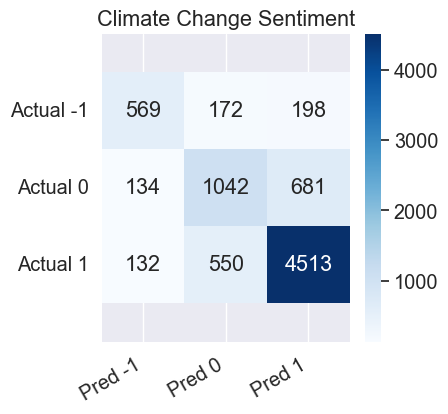

In [283]:
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

We also need a reference to vectors for each word found in the dataset. The word dictionary will be exported as a JSON file. Each unique word in the dataset is associated with its vector value.


In [284]:
# with open("wordDictionary.json", "w") as fp:
#     json.dump(vectorDictionary, fp)